In [1]:
library(dplyr)
library(tidyr)
library(tibble)
library(ggplot2)
library(stringr)
library(ggrepel)
library(ggh4x)
library(ggpubr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
df<-read.csv('03_FlowData/NK_Flow.csv',check.names = FALSE)


In [3]:
df<-df[!is.na(df$`clr_Adaptive NK`),]

In [6]:
unique(df$group)

[1] "Negative-Young" "Negative-Older" "Positive-Young" "Positive-Older"

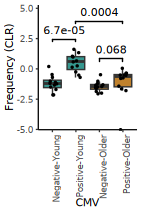

In [48]:
options(repr.plot.width = 30/25.4, repr.plot.height = 45/25.4)
df$`Age Group`<-factor(df$`Age Group`,levels=c("Young","Older"))
df$group=paste0(df$CMV,'-',df$`Age Group`)
df$group=factor(df$group,levels=c("Negative-Young","Positive-Young","Negative-Older", "Positive-Older"))
my_comparisons <- list(c("Negative-Young", "Positive-Young"),c("Negative-Older", "Positive-Older"),c("Positive-Young", "Positive-Older"))

p<-ggplot(df, aes(x=group, y=`clr_Adaptive NK`,fill=CMV	)) +
    geom_boxplot( aes(fill=`Age Group`	),outlier.shape = NA,lwd=0.3) +
geom_point(position = position_jitter(width = 0.2),color="black", size=0.7,stroke=0) +
theme_classic(base_size=6)+  
stat_compare_means(aes(label = paste0("p=", after_stat(p.format))),comparisons=my_comparisons[1],
    size=2.2,label.y=2.1,
    vjust = -0.5)+  
stat_compare_means(aes(label = paste0("p=", after_stat(p.format))),comparisons=my_comparisons[2],
    size=2.2,label.y=0.5,
    vjust = -0.5)+  
stat_compare_means(aes(label = paste0("p=", after_stat(p.format))),comparisons=my_comparisons[3],
    size=2.2, label.y=3.6,
    vjust = -0.5)+theme(strip.background = element_rect(linewidth = 0.5))+
    scale_fill_manual(values = c("Older" = '#bf812d', "Young" = '#35978f'))+
    scale_y_continuous(limits = c(NA, NA), 
                       expand = expansion(mult = c(0, 0.15)))+
theme(legend.position="none")+
xlab('CMV')+
ylab('Frequency (CLR)')+ theme(axis.text.x = element_text(angle = 90, hjust=1))
p
ggsave('FigureD.pdf',p,width = 30/25.4,height = 45/25.4)